In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from hol.count_wpm import CountWPM
from hol.anchored_count_wpm import AnchoredCountWPM

year1 = 1750
year2 = 1920

wpm0 = CountWPM(year1, year2)
wpm1 = AnchoredCountWPM(year1, year2)

### Raw WPM series

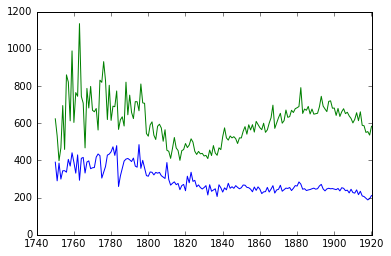

In [2]:
series = wpm0.series('art')
plt.plot(*zip(*series.items()))

series = wpm1.series('art')
plt.plot(*zip(*series.items()))

### Smoothed WPM series

0.899916078097 4.36387780883e-62


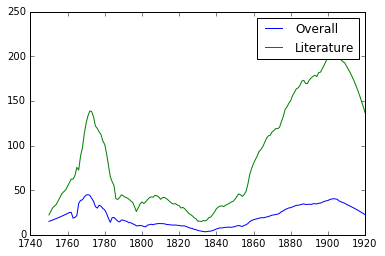

In [122]:
from collections import OrderedDict
from scipy.stats import pearsonr

def plot_token(token):

    s1 = wpm0.series_smooth(token)
    plt.plot(*zip(*s1.items()), label='Overall')

    s2 = wpm1.series_smooth(token)
    plt.plot(*zip(*s2.items()), label='Literature')
    
    plt.legend(loc='upper right')
    
    s1_resized = OrderedDict([
        (year, s1[year])
        for year in s2.keys()
    ])
    
    vals1 = list(s1_resized.values())
    vals2 = list(s2.values())
    
    corr, p = pearsonr(vals1, vals2)
    print(corr, p)
    
plot_token('shakespeare')

### Distinctive words, 20-year buckets

In [111]:
from hol.models import AnchoredCount

buckets = [
    (1740, 1760),
    (1760, 1780),
    (1780, 1800),
    (1820, 1840),
    (1840, 1860),
    (1860, 1880),
    (1880, 1900),
    (1900, 1920),
]

tokens = set()

for y1, y2 in buckets:
    mdws = AnchoredCount.mdw(y1, y2)
    tokens.update(list(mdws.keys())[:500])

### Pearson correlation - overall vs. "literature" pages

In [112]:
corrs = OrderedDict()
for token in tokens:
    
    s1 = wpm0.series_smooth(token)
    s2 = wpm1.series_smooth(token)
    
    s1_resized = OrderedDict([
        (year, s1[year])
        for year in s2.keys()
    ])
    
    vals1 = list(s1_resized.values())
    vals2 = list(s2.values())
    
    corr, p = pearsonr(vals1, vals2)
    
    if p < 0.05:
        corrs[token] = (corr, p)

corrs = OrderedDict(sorted(
    corrs.items(),
    key=lambda x: x[1][0],
))

for t, (c, p) in list(corrs.items())[:1000]:
    print(t, c, p)

improvements -0.75090084092 2.87664171918e-32
liable -0.704087580234 6.47943850922e-27
improved -0.660320786057 8.82929338548e-23
gross -0.59945802273 4.62001379406e-18
specimen -0.599005855068 4.96580124002e-18
court -0.566878513711 6.34836834671e-16
applied -0.549151347865 7.42156750662e-15
estate -0.546032033858 1.12704320853e-14
branches -0.469683364784 9.13337285299e-11
paid -0.463757648852 1.68034064398e-10
blood -0.420364308058 1.03989301629e-08
models -0.414931295335 1.84622326962e-08
improvement -0.396954465726 7.64602335209e-08
application -0.357565918144 1.57735886213e-06
london -0.348704732392 2.95370086976e-06
defendant -0.313028935146 5.57166969495e-05
seems -0.278348074668 0.000227540219796
warrant -0.253690067489 0.000843564239959
trial -0.249754934817 0.00098638471471
employment -0.234310827671 0.00203829309903
academy -0.226175106033 0.00293395627154
at -0.213088046513 0.00513784564244
branch -0.210665866347 0.00567979786881
under -0.207097699576 0.00657136567973
juri